In [1]:
import tensorflow as tf
from tensorflow import keras
import urllib3
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import imgaug.augmenters as iaa

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [3]:
ds_info.features["label"].names[:10]

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound']

In [4]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

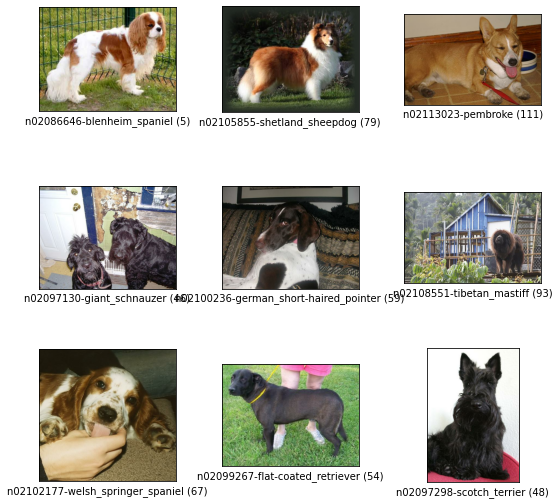

In [5]:
fig = tfds.show_examples(ds_train, ds_info)

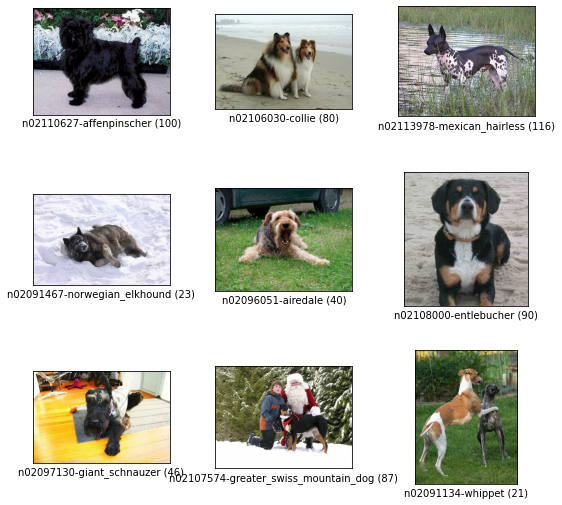

In [6]:
fig = tfds.show_examples(ds_test, ds_info)

# Augmentation 함수

### 이번 프로젝트에 쓸 Augmentation:

#### 1. 기본 Augmentation
#### 2. Cutmix Augmentation
#### 3. Mixup Augmentation

## 기본 Augmentation

In [7]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label


In [8]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label


## Cutmix Augmentation

In [9]:
def get_clip_box(image_a, image_b, img_size=224):
    # 박스의 위치를 이동시킴
    x = tf.cast( tf.random.uniform([],30, img_size-30),tf.int32)
    y = tf.cast( tf.random.uniform([],30, img_size-30),tf.int32)
    
    # with를 150으로 고정시킴
    width = 120
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [10]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [11]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = 0.3

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label


In [12]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Mixup Augmentation

In [13]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    # 알파를 0.2로 고정
    a = 0.5
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [14]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## onehot 함수

In [15]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

## Augmentation을 적용해서 데이터셋을 만들어 보기

In [16]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_img=False, with_aug=False, 
                               with_cutmix=False, with_mixup=False,
                               one_hot=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup, 
            num_parallel_calls=2
        )
    if is_test and one_hot:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


# MODEL 

## 여기서 기본 Augumentation 적용 모델 하기 

In [17]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

94773248/94765736 [==============================] - 1s 0us/step


## imgaug 적용하는 모델

In [18]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## Cutmix 적용하는 모델

In [19]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## Mixup 적용하는 모델 

In [20]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [22]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test_no = apply_normalize_on_dataset(ds_test, is_test = True)
ds_test_one = apply_normalize_on_dataset(ds_test, one_hot=True, is_test = True)


In [23]:
print(ds_train_cutmix)


<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>


## 함수 동작 확인하기

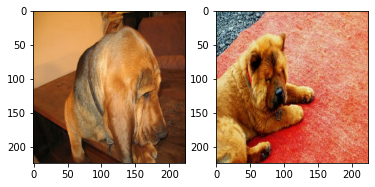

In [24]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

## MIXUP 확인

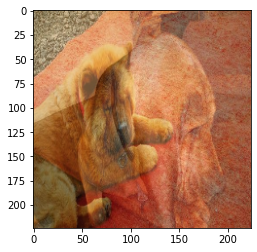

In [25]:
mixed_image, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_image.numpy())


#### 생각보다 MIXUP을 쓰니. 강아지가 합친것 보다, 여기 보이는 것 처럼 치와와가 흐릿하게 나오네요!

In [26]:
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. ], dtype=float32)>

## CutMix 확인하기

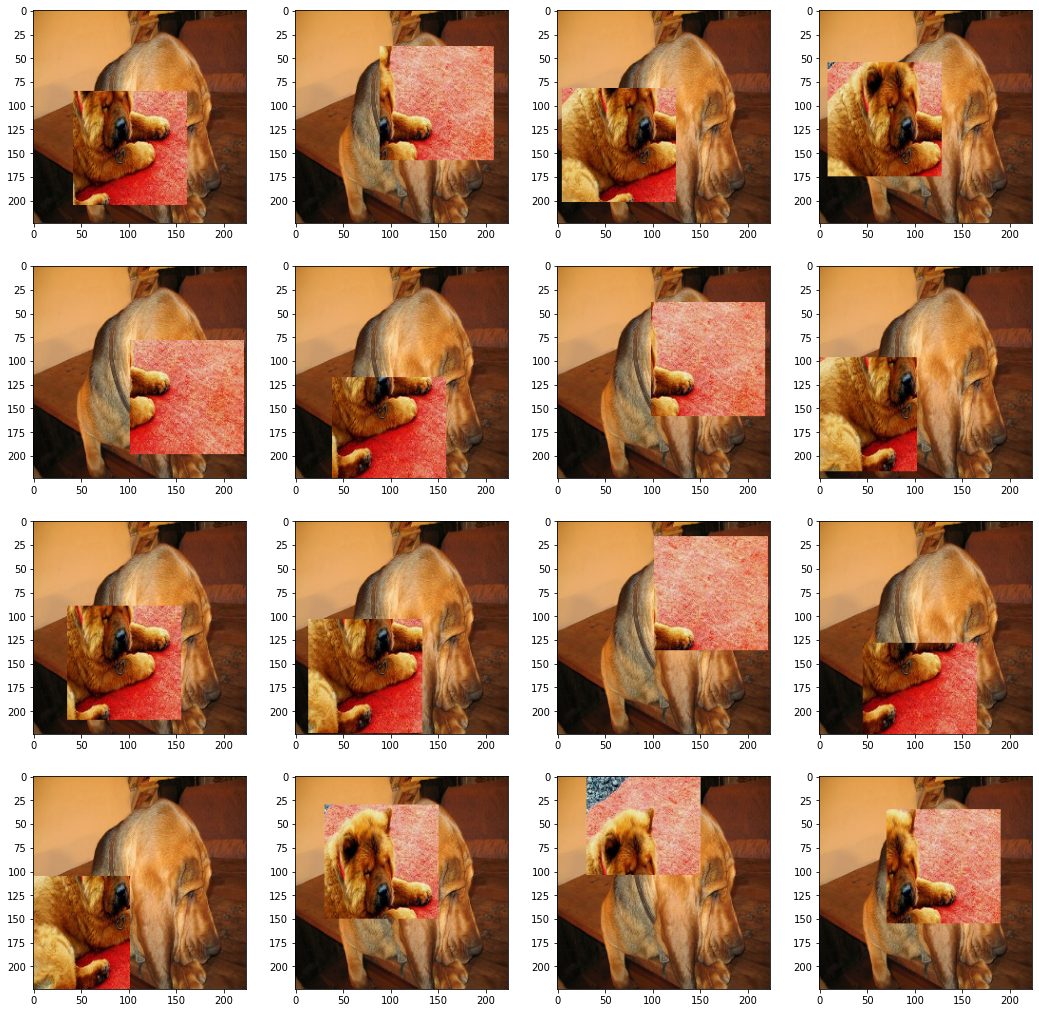

In [27]:
plt.figure(figsize=(18,18))
for i in range(16):
    plt.subplot(4, 4, i+1)
    xa, ya, xb, yb = get_clip_box(image_a, image_b)
    mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
    plt.imshow(mixed_img.numpy())

In [28]:
mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.7,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. ], dtype=float32)>

#### CUTMIX를 사용했을때, '이미지 2'가 조각으로 붙여있는 모십이 나온다.

## Model Epoch Data Training

In [29]:
tf.random.set_seed(2021)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [30]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_no,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 367s 449ms/step - loss: 3.1954 - accuracy: 0.2780 - val_loss: 3.3177 - val_accuracy: 0.2114
Epoch 2/15
750/750 [==============================] - 337s 450ms/step - loss: 0.8457 - accuracy: 0.7647 - val_loss: 1.0293 - val_accuracy: 0.6969
Epoch 3/15
750/750 [==============================] - 338s 450ms/step - loss: 0.2767 - accuracy: 0.9407 - val_loss: 0.9850 - val_accuracy: 0.7130
Epoch 4/15
750/750 [==============================] - 337s 449ms/step - loss: 0.0822 - accuracy: 0.9908 - val_loss: 0.9503 - val_accuracy: 0.7252
Epoch 5/15
750/750 [==============================] - 336s 448ms/step - loss: 0.0486 - accuracy: 0.9968 - val_loss: 0.9203 - val_accuracy: 0.7367
Epoch 6/15
750/750 [==============================] - 337s 449ms/step - loss: 0.0250 - accuracy: 0.9985 - val_loss: 0.9122 - val_accuracy: 0.7436
Epoch 7/15
750/750 [==============================] - 335s 446ms/step - loss: 0.0134 - accuracy: 0.9996 - val_loss: 0.9344 -

In [31]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_no,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 344s 448ms/step - loss: 3.2001 - accuracy: 0.2733 - val_loss: 2.9596 - val_accuracy: 0.2744
Epoch 2/15
750/750 [==============================] - 333s 444ms/step - loss: 1.0614 - accuracy: 0.6999 - val_loss: 1.2860 - val_accuracy: 0.6267
Epoch 3/15
750/750 [==============================] - 333s 444ms/step - loss: 0.5352 - accuracy: 0.8585 - val_loss: 1.0714 - val_accuracy: 0.6873
Epoch 4/15
750/750 [==============================] - 333s 445ms/step - loss: 0.2601 - accuracy: 0.9418 - val_loss: 1.0488 - val_accuracy: 0.7041
Epoch 5/15
750/750 [==============================] - 334s 445ms/step - loss: 0.1328 - accuracy: 0.9744 - val_loss: 1.0626 - val_accuracy: 0.7028
Epoch 6/15
750/750 [==============================] - 334s 445ms/step - loss: 0.0706 - accuracy: 0.9897 - val_loss: 0.9954 - val_accuracy: 0.7245
Epoch 7/15
750/750 [==============================] - 333s 445ms/step - loss: 0.0431 - accuracy: 0.9952 - val_loss: 0.9883 -

In [32]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_one,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 349s 453ms/step - loss: 4.5361 - accuracy: 0.0869 - val_loss: 3.0608 - val_accuracy: 0.2533
Epoch 2/15
750/750 [==============================] - 336s 448ms/step - loss: 3.3805 - accuracy: 0.3435 - val_loss: 1.6722 - val_accuracy: 0.5573
Epoch 3/15
750/750 [==============================] - 337s 449ms/step - loss: 3.0319 - accuracy: 0.4715 - val_loss: 1.4582 - val_accuracy: 0.6156
Epoch 4/15
750/750 [==============================] - 337s 450ms/step - loss: 2.8071 - accuracy: 0.5372 - val_loss: 1.4963 - val_accuracy: 0.6210
Epoch 5/15
750/750 [==============================] - 336s 448ms/step - loss: 2.6499 - accuracy: 0.6037 - val_loss: 1.2469 - val_accuracy: 0.6693
Epoch 6/15
750/750 [==============================] - 336s 448ms/step - loss: 2.4988 - accuracy: 0.6456 - val_loss: 1.3765 - val_accuracy: 0.6397
Epoch 7/15
750/750 [==============================] - 336s 449ms/step - loss: 2.3784 - accuracy: 0.6800 - val_loss: 1.4076 -

In [33]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_one,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 348s 453ms/step - loss: 4.7460 - accuracy: 0.0302 - val_loss: 4.1737 - val_accuracy: 0.0917
Epoch 2/15
750/750 [==============================] - 337s 449ms/step - loss: 3.9414 - accuracy: 0.1410 - val_loss: 1.9268 - val_accuracy: 0.4787
Epoch 3/15
750/750 [==============================] - 338s 450ms/step - loss: 3.6479 - accuracy: 0.1841 - val_loss: 1.6347 - val_accuracy: 0.5485
Epoch 4/15
750/750 [==============================] - 339s 452ms/step - loss: 3.4328 - accuracy: 0.2255 - val_loss: 1.5959 - val_accuracy: 0.5577
Epoch 5/15
750/750 [==============================] - 336s 448ms/step - loss: 3.3173 - accuracy: 0.2535 - val_loss: 1.6558 - val_accuracy: 0.5464
Epoch 6/15
750/750 [==============================] - 337s 449ms/step - loss: 3.2000 - accuracy: 0.2831 - val_loss: 1.5337 - val_accuracy: 0.5730
Epoch 7/15
750/750 [==============================] - 338s 451ms/step - loss: 3.1288 - accuracy: 0.2954 - val_loss: 1.5762 -

### Result:

#### Resnet50 _mixup 이 생각보다 정확도가 그렇게 높지가 않다. 
#### 그리고 augmentation and no augmentation는 그렇게 차이 많이 없는것같아 적확도에